# Import

In [126]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
# Фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [3]:
# Загружаем данные
df_train = pd.read_csv('main_task_new.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [8]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [9]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [61]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

Как видим, большинство признаков у нас требует очистки и предварительной обработки.

In [66]:
# Переименуем колонки для удобства
data.rename(columns={'Restaurant_id':'restaurant_id','City':'city','Cuisine Style':'cuisine_style','Ranking':'ranking',
                    'Price Range':'price_range','Number of Reviews':'number_of_reviews','Reviews':'reviews','Rating':'rating'}, inplace=True)

# Обработка данных и Feature Engineering

### Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [67]:
data.isna().sum()

restaurant_id            0
city                     0
cuisine_style        11590
ranking                  0
price_range          17361
number_of_reviews     3200
reviews                  2
URL_TA                   0
ID_TA                    0
sample                   0
rating                   0
dtype: int64

In [68]:
# Пока обработаем только пропуски в признаке Number of Reviews. В отдельный признак вынесем информацию о пропусках в этом столбце
data['number_of_reviews_isNAN'] = pd.isna(data['number_of_reviews']).astype('uint8')

In [69]:
# Далее заполняем пропуски нулями
data['number_of_reviews'].fillna(0, inplace=True)

**Для начала посмотрим количество уникальных значений.**

In [70]:
# Бросается в глаза, что Restaurant_id - это не уникальный идентификатор ресторана. Скорей всего, это идентификатор сети
# ресторанов.
data.nunique(dropna=False)

restaurant_id              13094
city                          31
cuisine_style              10732
ranking                    12975
price_range                    4
number_of_reviews           1574
reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
rating                        10
number_of_reviews_isNAN        2
dtype: int64

**Нарисуем графики имеющихся в датасете непрерывных переменных**

In [71]:
numeric_columns=['ranking', 'number_of_reviews','rating']

In [72]:
# Функция для построения графиков типа boxplot
def get_boxplot(df, column):
    fig, axes = plt.subplots(ncols=2, figsize=(6, 4))

    sns.boxplot(data=df[column], orient="h",
                 palette="Set2", whis=1.5, ax=axes[0]);
    df[column].hist(bins=20, ax=axes[1])
    fig.tight_layout(rect=[-1, 0.03, 1, 0.95])
    plt.title(column)
    plt.show()

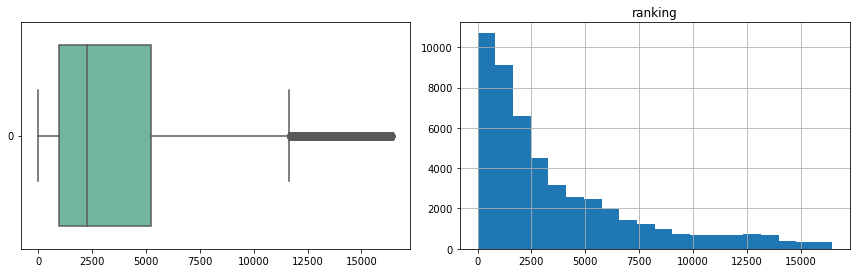

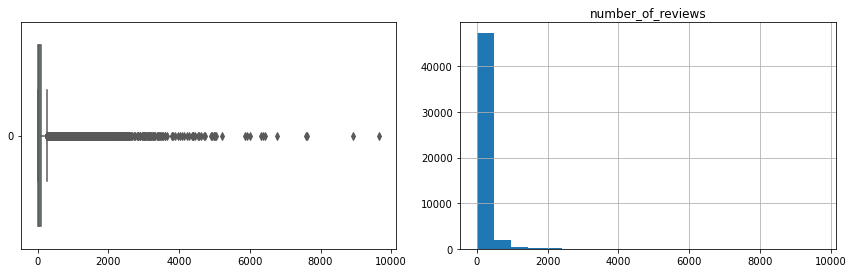

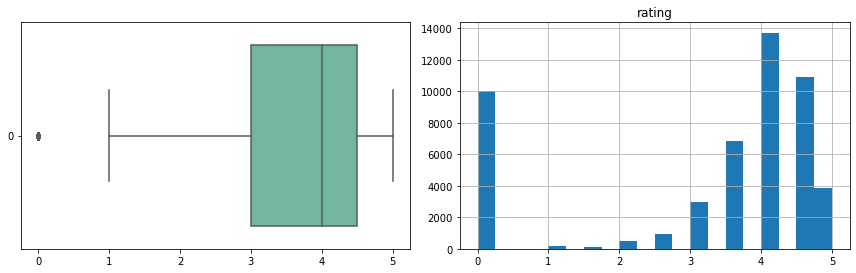

In [73]:
# Нарисуем боксплоты вместе с гистограммами для числовых признаков
for col in numeric_columns:
    get_boxplot(data, col)

In [74]:
# Целевая переменная rating имеет дискретное распределение. Признак number_of_reviews надо прологарифмировать, чтобы избавиться
# от тяжелого правогоо хвоста
data['number_of_reviews']=data['number_of_reviews'].apply(lambda x: np.log(x+1))

### Обработка признака Price Range

In [75]:
data['price_range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: price_range, dtype: int64

In [76]:
# заполним пропуски модой (наиболее часто встречающимся значением)
data["price_range"]=data["price_range"].fillna("$$ - $$$")

In [77]:
# функция, которая заменит строковые значения на float
def price_cat(string):
    if string=="$$ - $$$":
        return 2.0
    elif string=="$":
        return 1.0
    elif string=="$$$$":
        return 3.0

In [78]:
data["price_range"]=data["price_range"].apply(price_cat)

In [79]:
data.sample(5)

,restaurant_id,city,cuisine_style,ranking,price_range,number_of_reviews,reviews,URL_TA,ID_TA,sample,rating,number_of_reviews_isNAN
26886,id_2188,Budapest,"['International', 'European', 'Hungarian']",2189.0,1.0,2.397895,"[['Ruin bar of Buda', 'Ha a nyüzsgő nagyvározs...",/Restaurant_Review-g274887-d10207008-Reviews-M...,d10207008,1,4.5,0
21725,id_3517,Barcelona,"['Mediterranean', 'Spanish', 'Seafood']",3518.0,2.0,4.859812,"[['I was hesitant but it turned out great', 'G...",/Restaurant_Review-g187497-d1467522-Reviews-Re...,d1467522,1,4.0,0
32355,id_5519,Milan,NaN,5522.0,2.0,1.098612,"[[], []]",/Restaurant_Review-g187849-d8339982-Reviews-Ca...,d8339982,1,3.0,0
1489,id_1489,Prague,NaN,3013.0,2.0,1.386294,[['Business lunch or dinner when meetings aro....,/Restaurant_Review-g274707-d1116240-Reviews-El...,d1116240,0,0.0,0
40853,id_1165,Stockholm,"['European', 'Swedish', 'Contemporary']",1166.0,2.0,2.772589,"[['Try The Swedish Meatballs!', 'Great Views o...",/Restaurant_Review-g189852-d4419182-Reviews-Pa...,d4419182,1,4.0,0


### Feature engineering

In [80]:
# Создадим словарь с количеством упоминаний каждого города в датасте. В первом приближении будем считать, что каждое упоминание 
# соответствует одному ресторану. Таким образом, в словаре будет содержаться количество ресторанов в каждом городе
dict_of_cities=dict(data['city'].value_counts())
dict_of_cities

{'London': 7193,
 'Paris': 6108,
 'Madrid': 3813,
 'Barcelona': 3395,
 'Berlin': 2705,
 'Milan': 2694,
 'Rome': 2589,
 'Prague': 1816,
 'Lisbon': 1647,
 'Vienna': 1443,
 'Amsterdam': 1372,
 'Brussels': 1314,
 'Hamburg': 1186,
 'Munich': 1145,
 'Lyon': 1126,
 'Stockholm': 1033,
 'Budapest': 1021,
 'Warsaw': 925,
 'Dublin': 836,
 'Copenhagen': 819,
 'Athens': 776,
 'Edinburgh': 745,
 'Zurich': 685,
 'Oporto': 642,
 'Geneva': 590,
 'Krakow': 554,
 'Oslo': 488,
 'Helsinki': 475,
 'Bratislava': 380,
 'Luxembourg': 263,
 'Ljubljana': 222}

In [81]:
# Добавим колонку с количеством ресторанов в данном городе
data["number_of_restaurants"]=data['city'].apply(lambda x: dict_of_cities[x])

In [82]:
# Далее введем очень важный признак: ранг ресторана, нормированный на количество ресторанов в данном городе
data["ranking_normed"]=data["ranking"]/data["number_of_restaurants"]

In [83]:
# Воспользуемся данными из сторонних источников (Википедия). Создадим словарь с информацией о 
# количестве жителей в каждом городе
number_of_citizens={'Amsterdam': 872_757,
 'Athens': 664_046,
 'Barcelona': 1_664_182,
 'Berlin': 3_644_826,
 'Bratislava': 437_725,
 'Brussels': 185_103,
 'Budapest': 1_752_286,
 'Copenhagen': 615_993,
 'Dublin': 1_173_179,
 'Edinburgh': 488_100,
 'Geneva': 200_548,
 'Hamburg': 1_841_179,
 'Helsinki': 656_611,
 'Krakow': 779_115,
 'Lisbon': 505_526,
 'Ljubljana': 284_355,
 'London': 8_961_989,
 'Luxembourg': 626_108,
 'Lyon': 506_615,
 'Madrid': 3_266_126,
 'Milan': 1_378_689,
 'Munich': 1_471_508,
 'Oporto': 237_591,
 'Oslo': 673_469,
 'Paris': 2_148_327,
 'Prague': 1_335_084,
 'Rome': 2_870_500,
 'Stockholm': 961_609,
 'Vienna': 1_897_491,
 'Warsaw': 1_790_658,
 'Zurich': 428_737}

In [84]:
# Добавим колонку в датасет с информацией о количестве жителей
data["number_of_citizens"]=data["city"].apply(lambda x: number_of_citizens[x])

In [85]:
# Введем новые признаки: 1. ранг ресторана, нормированный на количество жителей в данном городе
# 2. количество отзывов, нормированное на количество жителей в каждом городе
data["ranking_norm_citizens"]=data["ranking"]/data["number_of_citizens"]
data["number_of_reviews_norm_citizens"]=data["number_of_reviews"]/data["number_of_citizens"]

In [86]:
# Воспользуемся дополнительной информацией о средней зарплате по городам из сторонних источников
salaries={'Amsterdam': 2155,
 'Athens': 894,
 'Barcelona': 1749,
 'Berlin': 2431,
 'Bratislava': 1043,
 'Brussels': 1920,
 'Budapest': 806,
 'Copenhagen': 3270,
 'Dublin': 2505,
 'Edinburgh': 1990,
 'Geneva': 4370,
 'Hamburg': 2431,
 'Helsinki': 2509,
 'Krakow': 934,
 'Lisbon': 1019,
 'Ljubljana': 1328,
 'London': 1990,
 'Luxembourg': 3416,
 'Lyon': 2225,
 'Madrid': 1749,
 'Milan': 1878,
 'Munich': 2431,
 'Oporto': 1019,
 'Oslo': 3309,
 'Paris': 2225,
 'Prague': 1207,
 'Rome': 1878,
 'Stockholm': 2570,
 'Vienna': 1830,
 'Warsaw': 934,
 'Zurich': 4370}

In [87]:
# Добавим признак salary - средняя зарплата в данном городе
data["salaries"]=data["city"].apply(lambda x: salaries[x])

In [88]:
# Нормируем колонку Ranking на средний уровень зарплат в каждом городе
data["ranking_norm_salaries"]=data["ranking"]/data["salaries"]

In [90]:
# возьмем get_dummies по городам
data = pd.get_dummies(data, columns=[ 'city'])

In [36]:
# Займемся колонкой cuisine_style. Выглядят данные как список, но на самом деле это строка
type(data["cuisine_style"][0])

str

In [91]:
# Напишем функцию, которая преобразует нашу колонку cuisine_style в список кухонь. Пропуски
# пока не заполняем! Мы сделаем это позже, когда будем считать количество кухонь в каждом ресторане
def make_list(x):
    if pd.isna(x)==True:
        return np.nan
    else:
        x=x.strip("[]")
        x=x.lower()
        x=x.replace('"\"',",")
        y=x.split(",")
        return y

In [92]:
data["cuisine_style_list"]=data["cuisine_style"].apply(make_list)

In [93]:
# Создадим функцию, возвращающую количество кухонь, предлагаемых в каждом ресторане. Если встречаем 
# пропуск, то считаем, что в данном ресторане предлагается только один тип кухни
def number_of_cuisines(x):
    if type(x)==list:
        return len(x)
    else:
        return 1

In [94]:
data["number_of_cuisines"]=data["cuisine_style_list"].apply(number_of_cuisines)

In [41]:
# Видим, что в названии кухни иногда первым символом идет пробел. Вот как здесь - " spanish"
data["cuisine_style_list"][99]

["'mediterranean'", " 'spanish'"]

In [34]:
# Напишем функцию, которая будет убирать эти пробелы.
def replace_spaces(list_of_cuisines):
    if type(list_of_cuisines)==list:
        list_of_values=[]
        for i in list_of_cuisines:
            if i[0]==" ":
                i=i.strip(" ")
                list_of_values.append(i)
            else:
                list_of_values.append(i)
        return list_of_values
    else:
        return np.nan

In [95]:
data["cuisine_style_list"]=data["cuisine_style_list"].apply(replace_spaces)

In [36]:
from datetime import datetime

In [45]:
# Обработаем колонку Reviews, содержащую сведения о дате отзыва. 
type(data["reviews"][11])

str

In [96]:
# Функция 'вытаскивает' информацию о дате отзыва(ов) и преобразует ее в тип datetime
def to_datetime(x):
    if pd.isna(x):
        return np.nan
    if x=="[[], []]":
        return np.nan
    x=x.strip("[[]]")
    if x[-2].isdigit()==True:
        date1=x[-11:-1]
    if x[-16].isdigit()==True:
        date2=x[-25:-15]
    else:
        return datetime.strptime(date1,"%m/%d/%Y")
    return [datetime.strptime(date1,"%m/%d/%Y"),datetime.strptime(date2,"%m/%d/%Y")]

In [97]:
# В колонку datetime поместим в виде списка объекты datetime - даты отзывов, оставленных на сайте
data["datetime"]=data["reviews"].apply(to_datetime)

In [98]:
# напишем функцию, которая считает, насколько дата отзыва(ов) отстоит от текущей даты. Если отзывов два,
# считается самый свежий отзыв
def time_delta(x):
    if type(x)==float:
        return np.nan
    if type(x)==datetime:
        return datetime.now()-x
    else:
        delta1=datetime.now()-x[0]
        delta2=datetime.now()-x[1]
        return min(delta1,delta2)

In [99]:
data["timedelta"]=data["datetime"].apply(time_delta)

In [100]:
# Данные в колонке timedelta хранятся в формате timedelta. Чтобы их можно было использовать в нашей модели,
# переведем их сначала в тип str, а затем в integer. Функцию см. ниже
def to_int(x):
    if pd.isna(x):
        return np.nan
    y=str(x)
    i=0
    while y[i].isdigit():
        i+=1
        z=y[:i]
    return int(z)

In [101]:
# Создадим колонку last_review, которая хранит количество дней от последнего отзыва на сайте о данном ресторане до сегодня
data["last_review"]=data["timedelta"].apply(to_int)

In [102]:
# Напишем функцию, которая будет считать время между двумя отзывами. Если отзыв один, будет 
# возвращаться NaN
def time_between(x):
    if type(x)==list:
        delta=abs(x[0]-x[1])
        return delta
    else:
        return np.nan

In [103]:
# В колонку time_between поместим время между двумя отзывами в формате timedelta
data["time_between"]=data["datetime"].apply(time_between)

In [104]:
# C форматом timedelta наша модель работать не умеет. Переведем его в int с помощью ранее написанной
# функции to_int
data["time_between"]=data["time_between"].apply(to_int)

**Теперь у нас появилось два числовых признака, в которых достаточно много пропусков (last_review, time_between). Для корректной работы модели нужно заполнить пропуски**

In [105]:
import random

In [106]:
# Напишем функцию, которая заменяет пропуски рандомными данными из тех, которые уже есть в данной колонке
def replace_with_interval(i,df):
    stat = df[i].value_counts(normalize=True)
    ind = df[df[i].isna()==True].index
    fill_list = pd.Series(random.choices(stat.index, stat, k=df[i].isna().sum()))
    fill_list.index = ind
    return fill_list

In [107]:
# Заполним пропуски в колонке last_review
replace_df=replace_with_interval("last_review",data)
data["last_review"].fillna(replace_df,inplace=True)

In [108]:
# Заменяем пропуски в колонке time_between
replace_df=replace_with_interval("time_between",data)
data["time_between"].fillna(replace_df,inplace=True)

In [109]:
data.columns

Index(['restaurant_id', 'cuisine_style', 'ranking', 'price_range',
       'number_of_reviews', 'reviews', 'URL_TA', 'ID_TA', 'sample', 'rating',
       'number_of_reviews_isNAN', 'number_of_restaurants', 'ranking_normed',
       'number_of_citizens', 'ranking_norm_citizens',
       'number_of_reviews_norm_citizens', 'salaries', 'ranking_norm_salaries',
       'city_Amsterdam', 'city_Athens', 'city_Barcelona', 'city_Berlin',
       'city_Bratislava', 'city_Brussels', 'city_Budapest', 'city_Copenhagen',
       'city_Dublin', 'city_Edinburgh', 'city_Geneva', 'city_Hamburg',
       'city_Helsinki', 'city_Krakow', 'city_Lisbon', 'city_Ljubljana',
       'city_London', 'city_Luxembourg', 'city_Lyon', 'city_Madrid',
       'city_Milan', 'city_Munich', 'city_Oporto', 'city_Oslo', 'city_Paris',
       'city_Prague', 'city_Rome', 'city_Stockholm', 'city_Vienna',
       'city_Warsaw', 'city_Zurich', 'cuisine_style_list',
       'number_of_cuisines', 'datetime', 'timedelta', 'last_review',
       

**У нас появилось довольно много новых непрерывных переменных. Посмотрим на их распределение (вместе со старыми)**

In [112]:
numeric_columns=['ranking', 'number_of_reviews','rating','number_of_restaurants', 'ranking_normed',
                'number_of_citizens', 'ranking_norm_citizens',
                'number_of_reviews_norm_citizens', 'salaries', 'ranking_norm_salaries', 'number_of_cuisines','last_review', 
                'time_between']

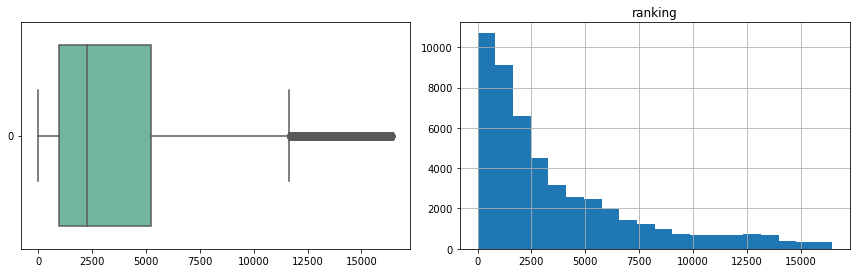

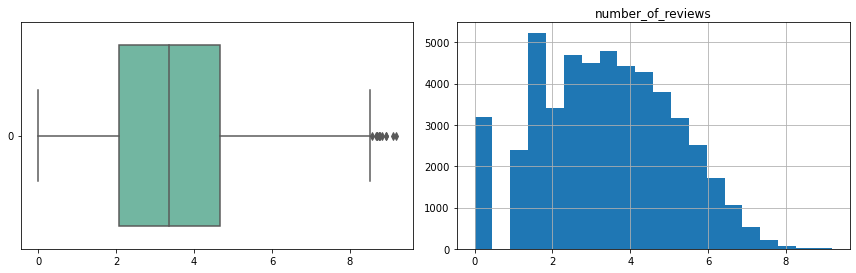

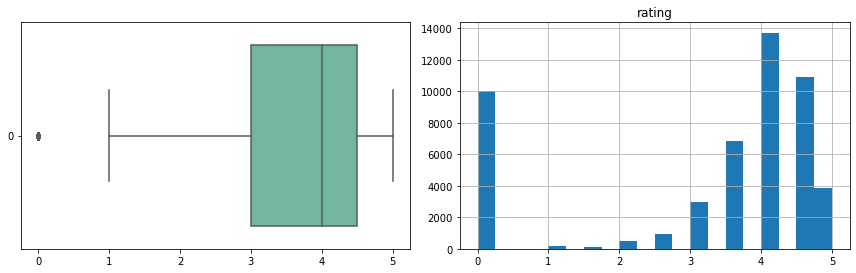

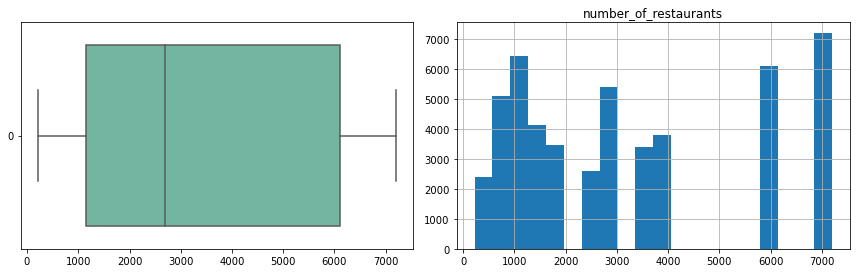

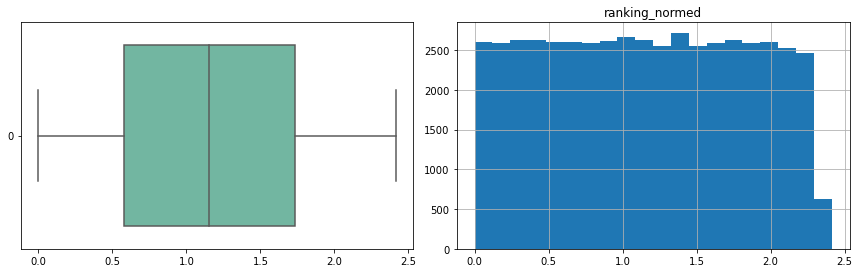

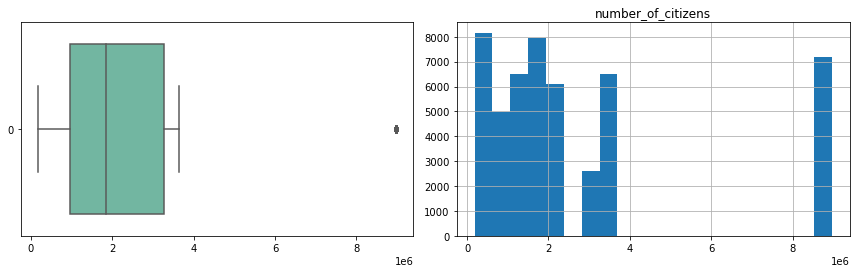

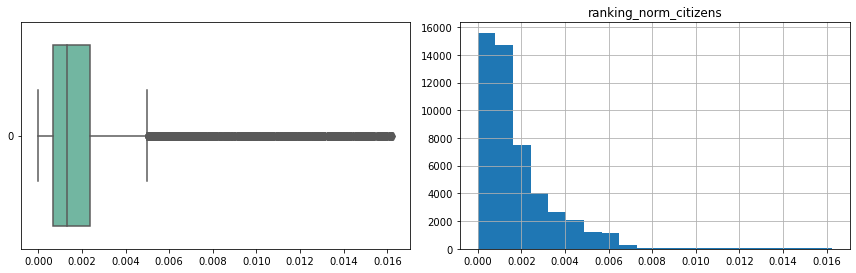

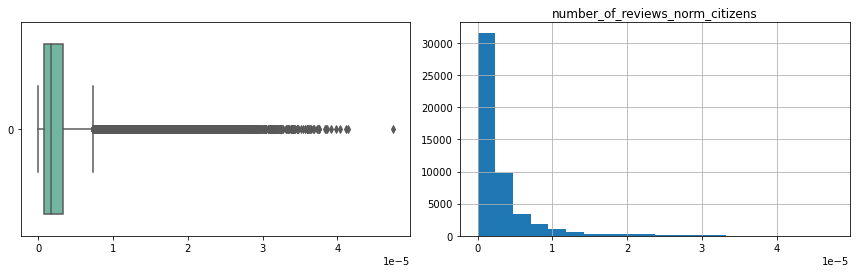

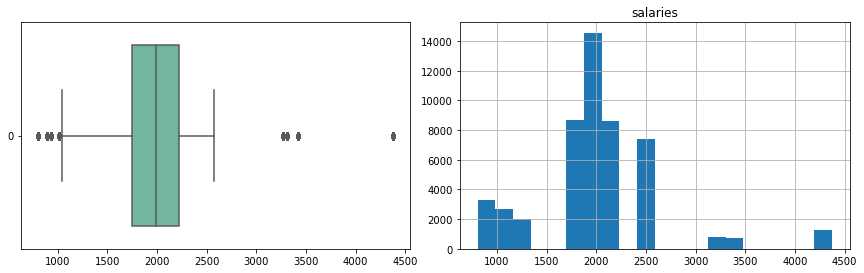

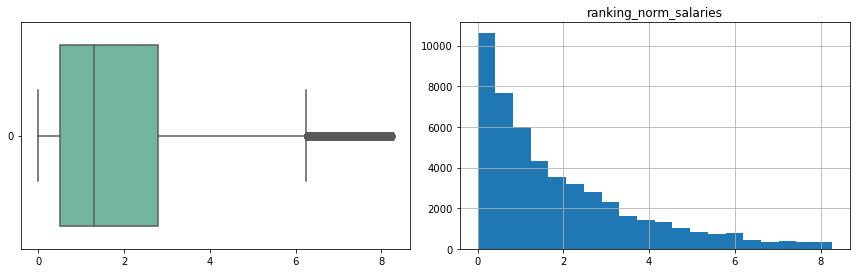

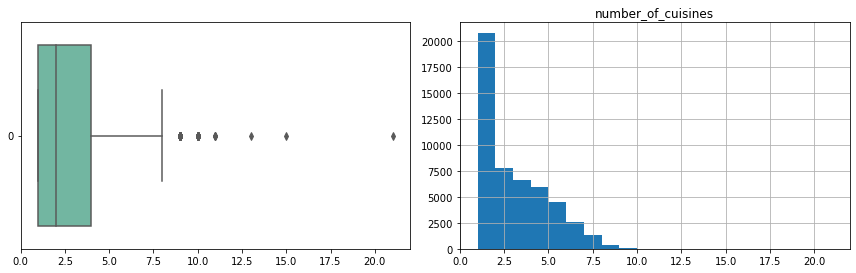

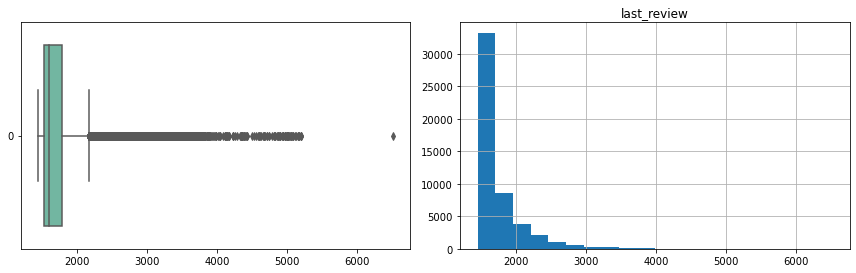

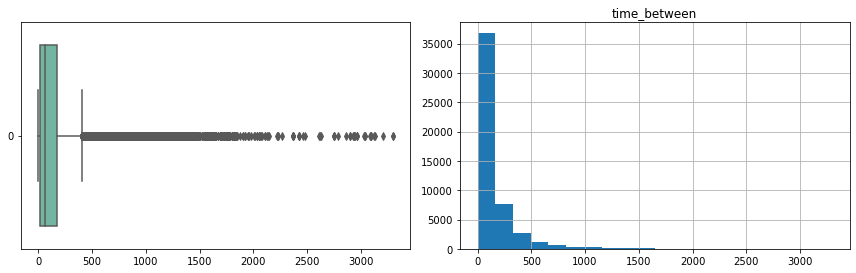

In [113]:
# Нарисуем боксплоты вместе с гистограммами для числовых признаков
for col in numeric_columns:
    get_boxplot(data, col)

In [114]:
# Прологарифмируем некоторые из наших новых признаков, чтобы избавиться от тяжелого правого хвоста
data['last_review']=data['last_review'].apply(lambda x: np.log(x+1))
data['time_between']=data['time_between'].apply(lambda x: np.log(x+1))

<AxesSubplot:>

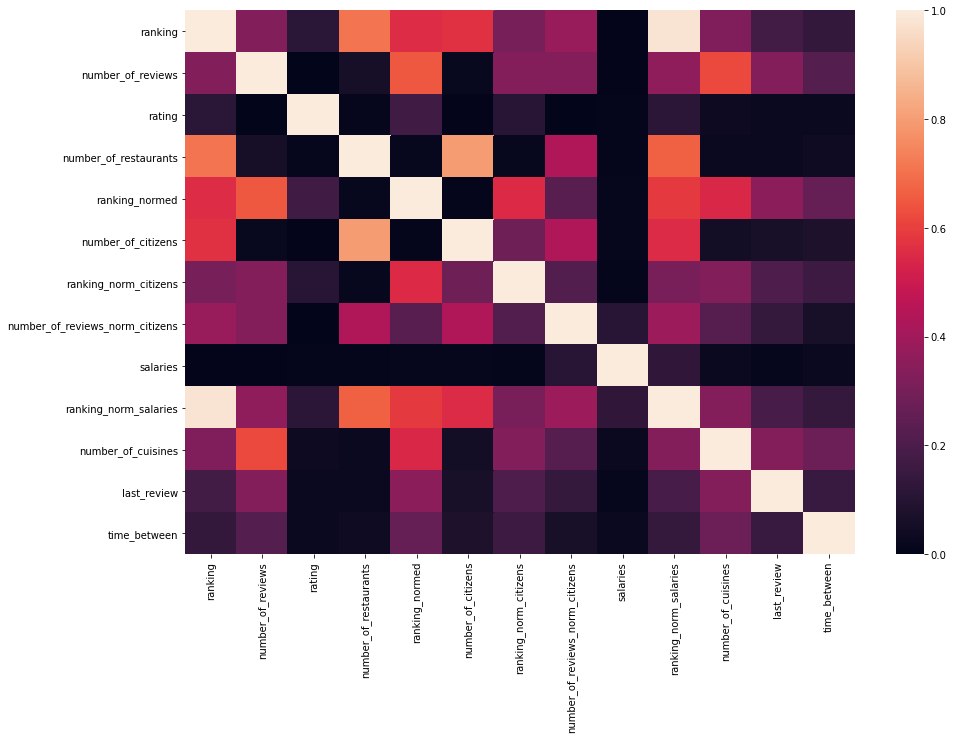

In [115]:
# Построим тепловую карту матрицы корреляции непрерывных признаков
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data[numeric_columns].corr().abs(), vmin=0, vmax=1)

**Мы видим, что некоторые признаки довольно сильно скоррелированы (ranking, number_of_restaurants, ranking_normed, number_of_citizens). Пока не будем ничего с ними делать. Т.к. наша модель - это случайный лес, а не линейная регрессия, то есть основания полагать, что сильная корреляция между некоторыми признаками не очень повлияет на итоговый результат.**

## Обработка признака reviews

In [117]:
# Начинаем работать с текстом отзывов в колонке reviews. Для начала переведем текст в нижний регистр
data["reviews"]=data["reviews"].apply(lambda x: x.lower() if type(x)==str else np.nan)

In [116]:
# Наша функция будет осуществлять поиск по ключевым словам, которые могут относиться к качеству еды в
# ресторане. В зависимости от найденных слов ресторану присваивается категория
def assign_category(x):
    if x=="[[], []]":
        return "unknown"
    if pd.isna(x):
        return "unknown"
    else:
        if x.find("excellent")>=0 or x.find("great")>=0 or x.find("tasty")>=0 or x.find("delicious")>=0 or x.find("very good")>=0 or x.find("best")>=0 or x.find("delight")>=0 or x.find("wonderful")>=0 or x.find("awsome")>=0 or x.find("amazing")>=0 or x.find("yummy")>=0:
            return "excellent"
        elif (x.find("good")>=0) or (x.find("lovely")>=0) or (x.find("nice")>=0) or (x.find("fun")>=0) or (x.find("authentic")>=0):
            return "good"
        elif (x.find("average")>=0) or (x.find("not bad")>=0) or (x.find("efficient")>=0):
            return "average"
        elif x.find("poor")>=0 or x.find("bad")>=0 or x.find("awful")>=0 or x.find("overpriced")>=0 or x.find("ugly")>=0 or x.find("greasy")>=0:
            return "bad"     
        else:
            return "unknown"

In [118]:
# Присвоим категорию "excellent","good","average","bad","unknown" каждому ресторану
data["restaurant_category"]=data["reviews"].apply(assign_category)

In [119]:
# Возьмем get_dummies по колонке restaurant_category
data=pd.get_dummies(data,columns=["restaurant_category"],dummy_na=False)

In [120]:
data.columns

Index(['restaurant_id', 'cuisine_style', 'ranking', 'price_range',
       'number_of_reviews', 'reviews', 'URL_TA', 'ID_TA', 'sample', 'rating',
       'number_of_reviews_isNAN', 'number_of_restaurants', 'ranking_normed',
       'number_of_citizens', 'ranking_norm_citizens',
       'number_of_reviews_norm_citizens', 'salaries', 'ranking_norm_salaries',
       'city_Amsterdam', 'city_Athens', 'city_Barcelona', 'city_Berlin',
       'city_Bratislava', 'city_Brussels', 'city_Budapest', 'city_Copenhagen',
       'city_Dublin', 'city_Edinburgh', 'city_Geneva', 'city_Hamburg',
       'city_Helsinki', 'city_Krakow', 'city_Lisbon', 'city_Ljubljana',
       'city_London', 'city_Luxembourg', 'city_Lyon', 'city_Madrid',
       'city_Milan', 'city_Munich', 'city_Oporto', 'city_Oslo', 'city_Paris',
       'city_Prague', 'city_Rome', 'city_Stockholm', 'city_Vienna',
       'city_Warsaw', 'city_Zurich', 'cuisine_style_list',
       'number_of_cuisines', 'datetime', 'timedelta', 'last_review',
       

In [121]:
# У нас есть интересная колонка - restaurant_id. Она содержит информацию о сетях ресторанов.
# Создадим словарь, куда запишем количество ресторанов в каждой сети
dict_of_nets=dict(data["restaurant_id"].value_counts())

In [122]:
data["net_size"]=data["restaurant_id"].apply(lambda x: dict_of_nets[x])

In [123]:
# Пронормируем два наших количественных признака на размер сети ресторанов
data["ranking_norm_net_size"]=data["ranking"]/data["net_size"]
data["number_of_reviews_norm_net_size"]=data["number_of_reviews"]/data["net_size"]

# Подготовка данных перед загрузкой в модель

In [124]:
data.columns

Index(['restaurant_id', 'cuisine_style', 'ranking', 'price_range',
       'number_of_reviews', 'reviews', 'URL_TA', 'ID_TA', 'sample', 'rating',
       'number_of_reviews_isNAN', 'number_of_restaurants', 'ranking_normed',
       'number_of_citizens', 'ranking_norm_citizens',
       'number_of_reviews_norm_citizens', 'salaries', 'ranking_norm_salaries',
       'city_Amsterdam', 'city_Athens', 'city_Barcelona', 'city_Berlin',
       'city_Bratislava', 'city_Brussels', 'city_Budapest', 'city_Copenhagen',
       'city_Dublin', 'city_Edinburgh', 'city_Geneva', 'city_Hamburg',
       'city_Helsinki', 'city_Krakow', 'city_Lisbon', 'city_Ljubljana',
       'city_London', 'city_Luxembourg', 'city_Lyon', 'city_Madrid',
       'city_Milan', 'city_Munich', 'city_Oporto', 'city_Oslo', 'city_Paris',
       'city_Prague', 'city_Rome', 'city_Stockholm', 'city_Vienna',
       'city_Warsaw', 'city_Zurich', 'cuisine_style_list',
       'number_of_cuisines', 'datetime', 'timedelta', 'last_review',
       

In [128]:
# Выделим трейн и тест
train_data = data.query('sample == 1').drop(columns=['sample','restaurant_id', 'cuisine_style','reviews', 'URL_TA', 'ID_TA',
                                                    'cuisine_style_list','datetime', 'timedelta'], axis=1)
test_data = data.query('sample == 0').drop(['sample','restaurant_id', 'cuisine_style','reviews', 'URL_TA', 'ID_TA',
                                                    'cuisine_style_list','datetime', 'timedelta','rating'], axis=1)

In [130]:
# Обработаем непрерывные признаки перед загрузкой в модель
train_data_numeric=train_data[['ranking', 'price_range','number_of_reviews','number_of_restaurants', 'ranking_normed',
       'number_of_citizens', 'ranking_norm_citizens',
       'number_of_reviews_norm_citizens', 'salaries', 'ranking_norm_salaries', 'number_of_cuisines','last_review',
       'time_between','net_size',
       'ranking_norm_net_size', 'number_of_reviews_norm_net_size']]
test_data_numeric=test_data[['ranking', 'price_range','number_of_reviews','number_of_restaurants', 'ranking_normed',
       'number_of_citizens', 'ranking_norm_citizens',
       'number_of_reviews_norm_citizens', 'salaries', 'ranking_norm_salaries', 'number_of_cuisines','last_review',
       'time_between','net_size',
       'ranking_norm_net_size', 'number_of_reviews_norm_net_size']]

# Я выбрала RobustScaler, т.к. он устойчив к выбросам
scaler=RobustScaler()
train_data_numeric=scaler.fit_transform(train_data_numeric)
test_data_numeric=scaler.transform(test_data_numeric)

In [131]:
# Подготовка данных
train_data_other=train_data.drop(columns=['rating','ranking', 'price_range','number_of_reviews','number_of_restaurants', 'ranking_normed',
       'number_of_citizens', 'ranking_norm_citizens',
       'number_of_reviews_norm_citizens', 'salaries', 'ranking_norm_salaries', 'number_of_cuisines','last_review',
       'time_between','net_size',
       'ranking_norm_net_size', 'number_of_reviews_norm_net_size'])
test_data_other=test_data.drop(columns=['ranking', 'price_range','number_of_reviews','number_of_restaurants', 'ranking_normed',
       'number_of_citizens', 'ranking_norm_citizens',
       'number_of_reviews_norm_citizens', 'salaries', 'ranking_norm_salaries', 'number_of_cuisines','last_review',
       'time_between','net_size',
       'ranking_norm_net_size', 'number_of_reviews_norm_net_size'])

X=np.hstack([train_data_numeric, train_data_other])
X_valid=np.hstack([test_data_numeric, test_data_other])

y=train_data['rating']

In [132]:
# выделим 20% данных на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [133]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 53), (40000, 54), (40000, 53), (32000, 53), (8000, 53))

# Model 

**По условию данной задачи, нужно пользоваться только RandomForestRegressor с заранее установленными параметрами. Другие модели
использовать нельзя. Метрика для оценки качества результата задана заранее - mean_absolute_error. Проверить на переобучение модель тоже нельзя.**

In [134]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [135]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [136]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   38.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [137]:
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20188687499999997


<AxesSubplot:>

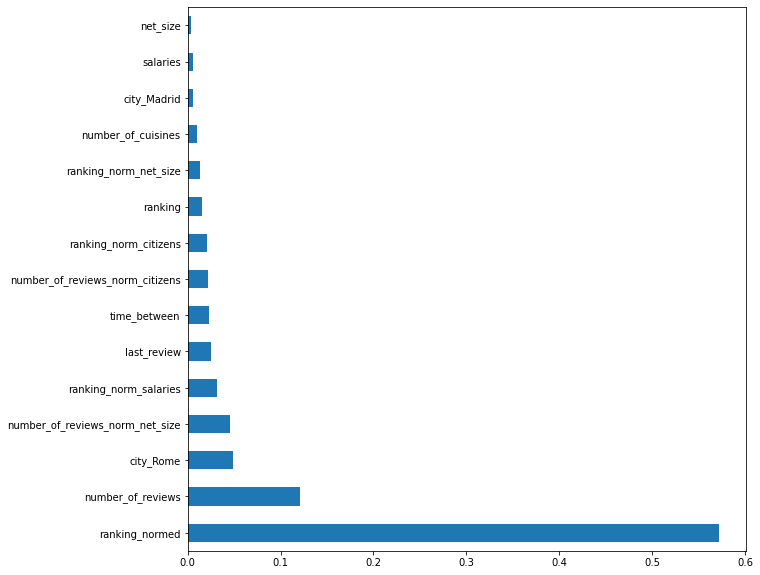

In [139]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
index=['ranking', 'price_range','number_of_reviews','number_of_restaurants', 'ranking_normed',
       'number_of_citizens', 'ranking_norm_citizens',
       'number_of_reviews_norm_citizens', 'salaries', 'ranking_norm_salaries', 'number_of_cuisines','last_review',
       'time_between','net_size',
       'ranking_norm_net_size', 'number_of_reviews_norm_net_size','number_of_reviews_isNAN','city_Amsterdam', 'city_Athens', 'city_Barcelona', 'city_Berlin',
       'city_Bratislava', 'city_Brussels', 'city_Budapest', 'city_Copenhagen',
       'city_Dublin', 'city_Edinburgh', 'city_Geneva', 'city_Hamburg',
       'city_Helsinki', 'city_Krakow', 'city_Lisbon', 'city_Ljubljana',
       'city_London', 'city_Luxembourg', 'city_Lyon', 'city_Madrid',
       'city_Milan', 'city_Munich', 'city_Oporto', 'city_Oslo', 'city_Paris',
       'city_Prague', 'city_Rome', 'city_Stockholm', 'city_Vienna',
       'city_Warsaw', 'city_Zurich', 'restaurant_category_average',
       'restaurant_category_bad', 'restaurant_category_excellent',
       'restaurant_category_good', 'restaurant_category_unknown']

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=index)
feat_importances.nlargest(15).plot(kind='barh')

## Выводы

**1. Цель данного соревнования - по максимуму использовать возможности обработки данных и feature engineering. В данном соревновании нельзя выбрать модель (может быть использован только RandomForestRegressor с заданными параметрами). Улучшение целевой метрики МАЕ может быть достигнуто только за счет добавления новых признаков и/или обработки старых.**

**2. В датасет были внесены 14 новых непрерывных признаков, не считая dummy-переменных. Непрерывные признаки были обработаны с помощью RobustScaler. Для генерации новых признаков были использованы внешние источники данных (например, Википедия).**

**3. Обработка данных и feature engineering позволили достичь значения метрики МАЕ, равного 0.2019.**

# Submission
Если все устраевает - готовим Submission на кагл

In [140]:
# Обучаем модель на всем трейне
model.fit(X,y)

predict_submission=model.predict(X_valid)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   46.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [110]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [112]:
predict_submission

array([3.135, 4.155, 4.485, ..., 3.11 , 4.415, 4.185])

In [141]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.060
1,id_1,4.280
2,id_2,4.490
3,id_3,4.280
4,id_4,4.495
5,id_5,4.425
6,id_6,1.350
7,id_7,2.910
8,id_8,4.070
9,id_9,4.565
